In [1]:
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import joblib


# This code creates a confusion matrix and an importance graph for a zone from the stored model for that zone.
# This first block loads the testing data that the figures will be generated from.

# Set these values to match the zone you are trying to look at, the "zone" value looks up, the second line only titles the figures
zone = "south" # north, central, or south
zone_name = "South Zone"

file_path = f'/home/evan/combinedZonesAllYears/{zone}ZoneCombined.csv'
input_dataframe = dd.read_csv(file_path)

X = input_dataframe.drop(columns=['Fire', 'Date', 'Longitude', 'Latitude'])  # Adjust columns as per your dataset
y = input_dataframe['Fire']

#compute dask dataframes
X_pd = X.compute()
y_pd = y.compute()

# split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)

Index(['SPEI', 'DewPointTemp', 'EVI', 'TA', 'LST', 'Wind', 'Elevation'], dtype='object')

South Zone Feature Importances Table:
Feature                        Importance
----------------------------------------
Thermal Anomalies              0.0064
Enhanced Vegetation Index      0.1075
Avg. Wind Speed                0.1145
Elevation                      0.1371
Land Surface Temp.             0.1455
Dew Point Temp.                0.2345
SPEI (Drought)                 0.2544


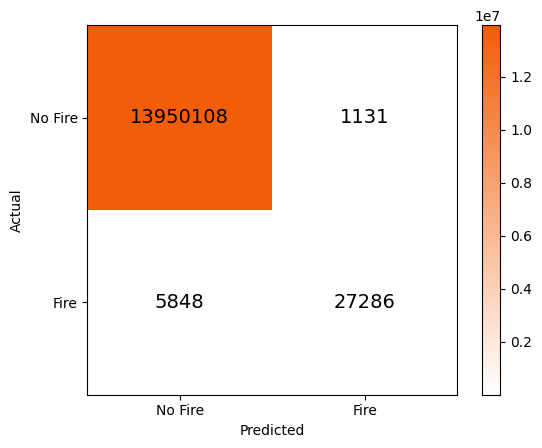

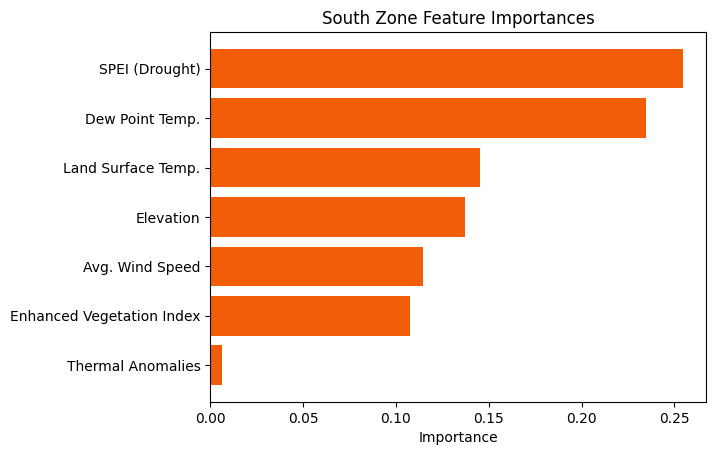

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# This code block creates the figures and loads the model 

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def plot_confusion_matrix(tn, fp, fn, tp, title="", hex_color='#F25D07', save_path=None, font_size=12): #title=f'{zone_name} Confusion Matrix',
    # Convert hex color to RGB
    rgb_color = hex_to_rgb(hex_color)
    
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, 1, 1), rgb_color])
    
    # Define the confusion matrix values
    cm = np.array([[tn, fp],
                   [fn, tp]])
    
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=font_size)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Set the ticks and labels for the x-axis (predicted)
    plt.xticks([0, 1], ['No Fire', 'Fire'])
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom of the plot
    
    # Set the ticks and labels for the y-axis (actual)
    plt.yticks([0, 1], ['No Fire', 'Fire'])

    # Save as PNG if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

def plot_feature_importances(model, feature_names, hex_color='#F25D07', save_path=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    fig, ax = plt.subplots()
    ax.barh(range(len(indices)), importances[indices], color=hex_color, align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Importance')
    ax.set_title(f'{zone_name} Feature Importances')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    
    # Print the feature importances as a table
    print(f"\n{zone_name} Feature Importances Table:")
    print(f"{'Feature':<30} {'Importance':<10}")
    print('-' * 40)
    for i in indices:
        print(f"{feature_names[i]:<30} {importances[i]:.4f}")

# Load the model from the joblib file

# Uncomment ONLY one of the following lines based on zone

model_path = f'{zone}AllYears.joblib'  # useable for south and central zone because they are not sampled
#model_path = "northAllYearsSampleForty.joblib" # only use for north because of the 40% sample

model = joblib.load(model_path)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Calculate confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Plot confusion matrix
plot_confusion_matrix(tn, fp, fn, tp, hex_color='#F25D07', save_path=f'{zone}customMatrix.png', font_size=14)

# Plot feature importances
feature_names = X_test.columns  # Assuming X_test is a pandas DataFrame
print(feature_names)
replacement = {'SPEI':"SPEI (Drought)", 'DewPointTemp': "Dew Point Temp.", 'EVI':"Enhanced Vegetation Index", 'TA': "Thermal Anomalies" , 'LST':"Land Surface Temp.", 'Wind': "Avg. Wind Speed", 'Elevation':"Elevation"}
modified_names = [replacement.get(name, name) for name in feature_names]
plot_feature_importances(model, modified_names, hex_color='#F25D07', save_path=f'{zone}featureImportances.png')
